In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import json
from shapely import geometry
from sklearn.manifold import TSNE 
import time

import numpy as np
import tensorflow as tf
from lxml import etree

In [ ]:
class DataProcessing:
  def __init__(self,dataDir):
    self.dataDir = dataDir
    self.folders = os.listdir(dataDir)
    self.allImgs = []
    self.allImgsPath = []
    self.annotations = {}
    self.totalFeatures = []
    self.imgFeatures = {}
    self.imgPathDict = {}
    self.partCoords = []

  def readJson(self,filePath):
    data = open(filePath)
    data = data.read()
    data = json.loads(data)
    return data

  def getPartCoords(self):
    dim1 = []
    for img in self.allImgs:
      # dim2 = []
      dim3 = []
      try:
        for item in self.annotations[img]['regions']:
          # features.append(item['region_attributes']['identity'])
          xCoords = item['shape_attributes']['all_points_x']
          yCoords = item['shape_attributes']['all_points_y']
          coordList = list(zip(xCoords , yCoords))
          dim3.append(coordList)
        dim1.append(dim3)
      except Exception as e:
        print("exception : ", e)
    return dim1



  def dataMerging(self):
   
    for folder in self.folders:
      subFolderPath = os.path.join(self.dataDir,folder)
      files = os.listdir(subFolderPath)
      for item in files:
        filePath = os.path.join(subFolderPath , item)
        if item.endswith('.json'):
          jsonDict = self.readJson(filePath)
          self.annotations = {**self.annotations , **jsonDict}
        else:
          self.allImgs.append(item)
          self.allImgsPath.append(filePath)
          self.imgPathDict[item] = filePath

  def getImgData(self,img,annotations):
  
    areas = {}
    _img = cv2.imread(self.imgPathDict[img])
    h = _img.shape[0]
    w = _img.shape[1]
    for item in annotations[img]['regions']:
    
      poly = geometry.Polygon(zip(item['shape_attributes']['all_points_x'],item['shape_attributes']['all_points_y']))
      # areas.append(poly.area / (h*w))
      areas[item['region_attributes']['identity']] = poly.area / (h * w)

    return areas


  def dataPrep(self):
    for imgName, val in self.annotations.items():
      features = []
      for i in val['regions']:
        feature = i['region_attributes']['identity']
        features.append(feature)
        self.totalFeatures.append(feature)
      self.imgFeatures[imgName] = np.unique(features)

  def getAllImages(self):
    return self.allImgs

  def getPartsArea(self):
    df = pd.DataFrame(columns=np.unique(self.totalFeatures))
    tot = []
    for ii in self.getAllImages():
      try:
        temp = self.getImgData(ii,self.annotations)
        temp = pd.DataFrame(temp,index=[self.imgPathDict[ii]])

        tot.append(temp)
      except Exception as e:
        print("error:",e)

    return pd.concat([df , *tot])


  def getPolyCoord(self, img):
    features = []
    xCoords = []
    yCoords = []
    areas = []
    _img = cv2.imread(self.imgPathDict[img])
    h = _img.shape[0]
    w = _img.shape[1]
    # print(self.imgFeatures[img])
    for item in self.annotations[img]['regions']:
      features.append(item['region_attributes']['identity'])
      xCoords.append(item['shape_attributes']['all_points_x'])
      yCoords.append(item['shape_attributes']['all_points_y'])
      # a square
      poly = geometry.Polygon(zip(item['shape_attributes']['all_points_x'],item['shape_attributes']['all_points_y']))
      areas.append(poly.area / (h*w))
      # print(poly.area)

    return {'feature' : features , 'x' : xCoords , 'y' : yCoords , 'area' : areas }

  def drawPolygon(self,img):
    imgInfo = self.getPolyCoord(img)
    img = cv2.imread(self.imgPathDict[img])
    for x , y in zip(imgInfo['x'] , imgInfo['y']):
      pts = np.array(list(zip(x,y))).reshape(-1,1,2)
      color = (random.random()*255, random.random()*255, random.random()*255)
      thickness = 4
     
      img = cv2.polylines(img, [pts] , isClosed=True ,color=color,thickness=thickness)

    return img

  def showImg(self,img):
      cv2_imshow(img)





    


In [ ]:
# class Annotations:
#   def __init__(self):
#     pass

#   def create_polygon_object_annotation(self,image_filenames, class_names_list, polygon_points_list):
#       # Create an XML element for the annotations
#       annotations = etree.Element('annotations')

#       for i, image_filename in enumerate(image_filenames):
#           # Create an annotation element for the current image
#           annotation = etree.Element('annotation')

#           # Add the filename of the image being annotated
#           filename = etree.Element('filename')
#           filename.text = image_filename
#           annotation.append(filename)

#           # Add the size of the image being annotated
#           size = etree.Element('size')
#           width = etree.Element('width')
#           height = etree.Element('height')
#           depth = etree.Element('depth')
#           size.extend([width, height, depth])
#           annotation.append(size)

#           # Add the objects being annotated
#           for j, polygon_points in enumerate(polygon_points_list[i]):
#               object_ = etree.Element('object')
#               name = etree.Element('name')
#               name.text = class_names_list[i][j]
#               object_.append(name)

#               # Add the polygon defining the object's location
#               polygon = etree.Element('polygon')
#               for point in polygon_points:
#                   point_element = etree.Element('point')
#                   x = etree.Element('x')
#                   x.text = str(point[0])
#                   y = etree.Element('y')
#                   y.text = str(point[1])
#                   point_element.extend([x, y])
#                   polygon.append(point_element)
#               object_.append(polygon)

#               annotation.append(object_)

#           # Add the annotation element to the annotations element
#           annotations.append(annotation)

#       # Return the XML element as a string
#       return etree.tostring(annotations, pretty_print=True)



In [ ]:
dataDir = '/content/drive/MyDrive/exercise_1'

obj = DataProcessing(dataDir)
obj.dataMerging()
obj.dataPrep()
imgg = obj.getAllImages()
len(imgg)

4006

In [ ]:
aa = obj.getPartCoords()

exception :  'scraped_fBGB6b_1649444860232 (1).jpg'
exception :  'scraped_waBj0k_1649439969130 (1).jpg'
exception :  'scraped_eKXS7j_1649444742594 (1).jpg'
exception :  'scraped_k3eT5z_1649439502351 (1).jpg'
exception :  'scraped_487XVF_1649444676314 (1).jpg'
exception :  'scraped_zyvVWW_1649439966514 (1).jpg'
exception :  'scraped_FarOZ9_1649439553008 (1).jpg'
exception :  'scraped_eF38WJ_1649440001198 (1).jpg'
exception :  'scraped_NRbvCX_1649444776260 (1).jpg'
exception :  'scraped_mvn6U4_1649439546452 (1).jpg'
exception :  'oIUbkqJxtr_1648015348422 (1).jpg'
exception :  'BBdANhUobr_1648015235218 (1).jpg'
exception :  'scraped_BRdkPU_1648037422271 (1).jpg'
exception :  'kMQGuqUoaV_1648015388805 (1).jpg'
exception :  '2bnYY7zS1O_1648015242958 (1).jpg'
exception :  'XSSLLw9w9O_1648015381392 (1).jpg'
exception :  'kiKN0MNi7r_1648015369599 (1).jpg'
exception :  '171xnrNbOG_1648015288715 (1).jpg'
exception :  't2XErOkMRZ_1648015282255 (1).jpg'
exception :  'kKIljKGAIx_1648015249318 (1).j

In [ ]:
import time
_dir = '/content/drive/MyDrive/exercise_1'
obj = DataProcessing(_dir)
obj.dataMerging()
obj.dataPrep()
st = time.time()
df = obj.getPartsArea()
print((time.time() - st)/60)
df_ori = df[:]
df.to_csv('partArea_11.csv')


In [ ]:
selected_features = df

selected_class_ids = range(0,df.shape[0])
selected_filenames = df.index.values
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
# Plot a scatter plot from the generated t-SNE results
# colormap = plt.cm.get_cmap('coolwarm')
# scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],c=range(0,df.shape[0]), cmap=colormap)
# # plt.color

x = tsne_results[:,0]
y = tsne_results[:,1]
len(x),len(y)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3974 samples in 0.004s...
[t-SNE] Computed neighbors for 3974 samples in 0.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3974
[t-SNE] Computed conditional probabilities for sample 2000 / 3974
[t-SNE] Computed conditional probabilities for sample 3000 / 3974
[t-SNE] Computed conditional probabilities for sample 3974 / 3974
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.294693
[t-SNE] KL divergence after 1000 iterations: 0.791515


(3974, 3974)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


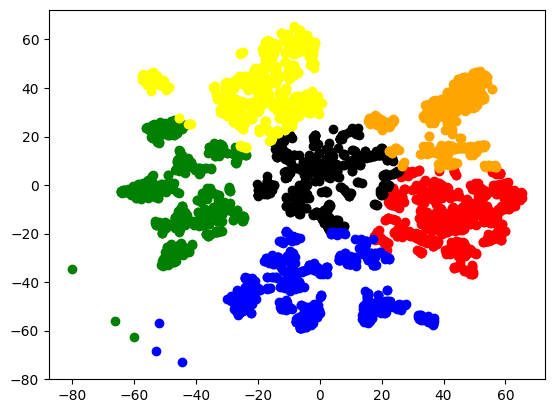

In [ ]:
from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(df)

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

#Load Data
# data = load_digits().data
# pca = PCA(2)

# #Transform the data
# df = pca.fit_transform(df)

# df.shape


kmeans = KMeans(n_clusters= 6)

#predict the labels of clusters.
df = tsne_results
label = kmeans.fit_predict(df)

import matplotlib.pyplot as plt

#filter rows of original data
filtered_label0 = df[label == 0]

#plotting the results
# plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
# plt.show()


#filter rows of original data
filtered_label2 = df[label == 2]

filtered_label5 = df[label == 5]
filtered_label1 = df[label == 1]

filtered_label3 = df[label == 3]
filtered_label4 = df[label == 4]

# filtered_label6 = df[label == 6]
# filtered_label7 = df[label == 7]
# filtered_label8 = df[label == 8]



#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1] , color = 'black')
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'green')

plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'orange')
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1] , color = 'blue')
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1] , color = 'yellow')

# plt.scatter(filtered_label6[:,0] , filtered_label6[:,1] , color = 'brown')
# plt.scatter(filtered_label7[:,0] , filtered_label7[:,1] , color = 'brown')
# plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'brown')


plt.show()

In [ ]:
import shutil

for i in range(6):
  mainPath = '/content/drive/MyDrive/carsData/labelFolder'
  dirPath = f"label_{i}"
  path = os.path.join(mainPath,dirPath)
  os.mkdir(path)

  tempDf = df_ori[label == i].index
  for file in tempDf:
    shutil.copy(file , path)


In [1]:
# For speed and clarity, we'll analyze about first half of the dataset.
# selected_features = np.array(df.columns).reshape(-1,1)
# selected_features = df

# selected_class_ids = range(0,3977)
# selected_filenames = df.index.values
# tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
# # Plot a scatter plot from the generated t-SNE results
# colormap = plt.cm.get_cmap('coolwarm')
# scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],c=range(0,df.shape[0]), cmap=colormap)
# # plt.color



In [ ]:
# from matplotlib.offsetbox import OffsetImage, Annotati

